# Implementation of Research Paper:
## Title: Time Series Classification Using Multi-Channels Deep Convolutional Neural Networks
## Authors: Yi Zheng1, Qi Liu, Enhong Chen, Yong Ge, and J. Leon Zhao
## Datasource: http://archive.ics.uci.edu/ml/datasets/pamap2+physical+activity+monitoring

In [1]:
from collections import Counter
from torch import nn
from torch.utils.data import DataLoader as DL , Dataset
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import warnings
warnings.filterwarnings('ignore')

### Data Preprocessing

In [2]:
from google.colab import drive
from torch.utils.tensorboard import SummaryWriter

drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/Colab Notebooks/pamap/"
summaries_path = "/content/gdrive/My Drive/Colab Notebooks/summaries/"
writer = SummaryWriter(summaries_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Each Subject's data is stored in a list called dataset
- Subject 8 has a different dominant hand
- Subject 9 performed different activties
- The two subjects were excluded from  the experiments by the authors



In [3]:
dataset = []
for file in os.listdir(path):
    dataset.append(pd.read_csv(path+file, delimiter = " ", low_memory = False, na_values = "na", header = None))
print("The dataset list contains data on ",len(dataset), "users")

The dataset list contains data on  7 users


#### Select rows with desired activites

- Using column 2 with activity index, rows containing the activies used by the authors are selected for each user.
- The activities are : standing, walking, ascending stairs and  descending stairs
- Each users data is then stored in a list `data`


In [4]:
data = []
num_users = len(dataset)
activities = [3,4,12,13]
for d in range(len(dataset)):
    #using column 2 with activity index
    #rows containing the activies used by the authors are selected
    data.append(dataset[d].loc[dataset[d][1].isin(activities)])
for i in range(len(data)):
    print("User ",i+1, " has ", len(data[i]), " timestamps")

User  1  has  75233  timestamps
User  2  has  87617  timestamps
User  3  has  81173  timestamps
User  4  has  74640  timestamps
User  5  has  88735  timestamps
User  6  has  74759  timestamps
User  7  has  90664  timestamps


-The following columns are deleted for the 3 IMU sensor data:
  - Timestamp is not needed
  - Heart rate because it has a different sampling frequency from the IMU
  - 3D acceleration data that was not properly calibrated
  - Orientation data was determined as invalid

-The target is the activity ID and for each user, it is stored in list `user_features`.
-The features for each user is stored in list `user_target`
-Rows with missing values ,`NaN`, are also dropped



In [5]:
pd.set_option('display.max_columns', 55)
col_to_del = [0,1,2,7,8,9,16,17,18,19,24,25,26,33,34,35,36,41,42,43,50,51,52,53]

user_features = []
user_target   = []
for user_data in data:
  user_data = user_data.dropna()
  user_target.append(user_data.iloc[:,1])
  user_features.append(user_data.drop(columns=col_to_del))

for i in range(len(data)):
    print("User ",i+1, " has ", len(user_features[i].iloc[0,:]), "features")

User  1  has  30 features
User  2  has  30 features
User  3  has  30 features
User  4  has  30 features
User  5  has  30 features
User  6  has  30 features
User  7  has  30 features


#### Standardizing the dataset for each user
To standardize each users data:
- The mean of the combination of all the users data was calculated
- The standard deviation of the combination of all the users data was calculated
- Using these global means, each user data was standardized



#### Standardizing the data

In [0]:
num_features = user_features[0].shape[1]
prod_mean_by_len = 0
data_len_of_all_users = 0
for user_data in user_features:
    #get the product of the mean of the user data and its data length
    prod_mean_by_len      += user_data.mean() * len(user_data)
    #store the length of the sum of all data points
    data_len_of_all_users += len(user_data)
#calculate the global mean
feature_means = prod_mean_by_len/data_len_of_all_users

squared_deviation_sum = 0
for user_data in user_features:
  #calculate the deviation of each feature from the mean
  deviation = user_data - feature_means
  #sum the square of the deviations
  squared_deviation_sum += (deviation**2).sum()
#calculate the global standard deviation
feature_standard_deviation = np.sqrt(squared_deviation_sum/data_len_of_all_users)

#standardize each users data
standardized_data = []
for user_data in user_features:
  standardized_data.append((user_data - feature_means)/feature_standard_deviation)

#### Create Dataset using sliding window  technique
- Below is a more memory and time efficient method of implementing the sliding window technique over concatenating individual windows
- The size of the expected dataset is calculated
- Each window is therefore inserted into the arrays to store the features and targets
- The windowed features and targets are returned. 

In [0]:
def generate_data(data_list,target_list,step):
  window = 256
  n_features = data_list[0].shape[1]
  data = []
  print("Start Processing for step ", step)
  for i in range(len(data_list)):
    features = data_list[i].values
    targets  = target_list[i].values
    
    sliding_pointer    = 0 #pointer for sliding through the data
    num_window_sampled = 0 #number of window samples collected
    
    last_window_stop = len(features) - window 
    num_window_slides = int(last_window_stop/step)

    windowed_features = np.zeros((num_window_slides, num_features,window))
    windowed_targets  = np.zeros((num_window_slides),dtype = "float32")
    
    for j in range(num_window_slides):
      windowed_features[num_window_sampled] = \
                            features[sliding_pointer:sliding_pointer+window].T
      
      #select the most frequent label in the window
      windowed_targets[num_window_sampled] = \
        Counter(targets[sliding_pointer:sliding_pointer+window]).most_common(1)[0][0]

      sliding_pointer += step
      num_window_sampled += 1
        
    data.append((windowed_features,windowed_targets))
  print("Processing completed for step ", step)
  return data














#### Creating train and test dataset using LOOCV
- Using the generate_data function, the sliding window operation generates data from each user
- To implement the LOOCV, one user's data is selected as test set while the others are concatenated to form the training set
- The targets are label encoded

In [8]:
X_train = np.empty((0,num_features,256))
y_train = np.empty(0)

step = 128
test_index = 6

data = generate_data(standardized_data,user_target,step)

X_test = data[test_index][0]
y_test = data[test_index][1]
y_test = pd.Series(y_test).map({3:0,4:1,12:2,13:3}).values
for i in range(num_users):
    if i != test_index:
      X_train = np.concatenate((X_train, data[i][0]), axis = 0)
      y_train = np.concatenate((y_train, data[i][1]))

y_train = pd.Series(y_train).map({3:0,4:1,12:2,13:3}).values
print("shape of Xtrain is ", X_train.shape)
print("shape of Ytrain is ", y_train.shape)
print("shape of Xtest is ", X_test.shape)
print("shape of Ytest is ", y_test.shape)

Start Processing for step  128
Processing completed for step  128
shape of Xtrain is  (324, 30, 256)
shape of Ytrain is  (324,)
shape of Xtest is  (61, 30, 256)
shape of Ytest is  (61,)


#### Creating MC-DCNN(2)
- The Dataset and DataLoaders are Created

In [0]:
class PAMAP(Dataset):
    """PAMAP dataset."""
    def __init__(self,X,y):
        """
        Args:
            X (numpy array): Array with input data
            y (numpy array): Array with labels
        """
        self.X = X
        self.y = y


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (torch.tensor(self.X[idx,:,:], dtype = torch.float32),
                torch.tensor(self.y[idx], dtype = torch.float32))

data_train_loader  = DL(dataset = PAMAP(X_train,y_train), batch_size = 1, shuffle = True)
data_test_loader   = DL(dataset = PAMAP(X_test,y_test), batch_size = 1, shuffle = False)

- The Class `MCDCNN` creates the neural network model
- Atrribute `conv_block` is a list that stores a sequence of convolution layers
- The amount of convolution layers is equal to the amount of channels. For this implementation, it amounts to 30
- Each conv layer in the each sequence is intialized in the for loop with `Xavier initialization` and the same pertains to the Linear Layers
- The input to the model is of shape `(1,30,256)`
  - To start the forward pass, the first dimension is squeezed out using `x = x[0]` to produce dimension `(30,256)`
  - Next, the for loop selects each channels and passes it through one of the conv layers in the `conv_block` list
  - The outputs are flattened and passed through a Feed Forward Network 


In [10]:
class MCDCNN(nn.Module):
  def __init__(self,channels):
    super().__init__()
    self.conv_block = []
    self.sigmoid = nn.Sigmoid()
    self.softmax = nn.Softmax()
    self.drop = nn.Dropout(0.8)
    self.channels = channels
    #append sequence of conv layers to conv_block
    for i in range(channels):
      self.conv_block.append(nn.Sequential(
              nn.Conv1d(1,8,5,1),
              nn.AvgPool1d(2,2),
              nn.Conv1d(8,4,5,1),
              nn.AvgPool1d(2,2)))
    
    #perform xavier intialization for conv layers
    for j in range(channels):  
      for i in range(4):
        i = str(i)
        if i in ["1","3"]:
          continue
        nn.init.xavier_uniform_(self.conv_block[j]._modules[i].weight)
    
    
    self.fc1 = nn.Linear(61*channels*4, 732)#(input node,output node)
    self.fc2 = nn.Linear(732, 4)
    
    nn.init.xavier_uniform_(self.fc1.weight)
    nn.init.xavier_uniform_(self.fc2.weight)
    
  
  def forward(self,x):
    x = x[0] #squeeze out first dimension
    #pass each channel to a conv layer in conv block
    for i in range(self.channels):
      x1 = x[i].view(-1,1,256)
      out = self.conv_block[i](x1)
      out = out.view(-1,4*61)
      #flattened outputs
      if i == 0:
        flat_layer = out
      else:
        flat_layer = torch.cat((flat_layer,out),1)
    #Linear Layers
    out = self.drop(out)
    out = self.sigmoid(self.fc1(flat_layer))
    out = self.softmax(self.fc2(out))
    return out

num_features = 30
model = MCDCNN(num_features)
model

MCDCNN(
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=None)
  (drop): Dropout(p=0.8, inplace=False)
  (fc1): Linear(in_features=7320, out_features=732, bias=True)
  (fc2): Linear(in_features=732, out_features=4, bias=True)
)

In [0]:
def accuracy(y,pred):
  pred = np.argmax(pred.detach().numpy(),axis = 1)
  y    = y.detach().numpy()
  return np.mean((pred == y).astype(float)) * 100  

def model_train(model,data_train_loader,data_test_loader, epochs = 50, freq = 1):
  n_batches_train = 0
  n_batches_test  = 0

  cost            = nn.CrossEntropyLoss()
  #optimizer       = torch.optim.SGD(model.parameters(),lr=0.001,\
  #                                  momentum=0.9, weight_decay=0.0005, nesterov=True)
  
  optimizer       = torch.optim.Adam(model.parameters(),lr=0.0001)
  train_loss      = []
  test_loss       = []
  train_acc_list  = []
  test_acc_list   = []

  for epoch in range(epochs):
    average_train_batch_loss = 0
    train_acc = 0

    average_test_batch_loss = 0
    test_acc = 0
    
    for batch_id,(X,y) in enumerate(data_train_loader):
      if epoch == 0:
        n_batches_train += 1

      prediction = model(X.float())
      loss = cost(prediction,y.long())
      optimizer.zero_grad()
      loss.backward()
      if batch_id == 0:
        writer.add_histogram('output layer gradients',model.fc2.weight,epoch)
      optimizer.step()
      
      prediction = model(X.float())
      loss = cost(prediction,y.long())
      
      average_train_batch_loss += loss.item()
      prediction = F.softmax(prediction)
      train_acc += accuracy(y,prediction)
    
    train_loss.append(average_train_batch_loss/n_batches_train)
    train_acc_list.append(float(train_acc)/n_batches_train)
    
    if (epoch+1) % freq == 0: 
      print(f"epoch: {epoch+1} average batch train loss:{train_loss[-1]}\
    average batch train accuracy:{train_acc_list[-1]}%")
      
    writer.add_scalar('train loss',train_loss[-1],epoch)
    writer.add_scalar('train accuracy',train_acc_list[-1],epoch)
    

    with torch.no_grad():
      for X,y in data_test_loader:
        if epoch == 0:
          n_batches_test += 1

        prediction = model(X.float())
        t_loss = cost(prediction,y.long())
        prediction = F.softmax(prediction)
        
        average_test_batch_loss += t_loss.item()
        test_acc  += accuracy(y,prediction)
      
      
      test_loss.append(average_test_batch_loss/n_batches_test)
      test_acc_list.append(float(test_acc)/n_batches_test)

      if (epoch+1) % freq == 0: 
        print(f"epoch: {epoch+1} test loss:{test_loss[-1]}\
                        test accuracy:{test_acc_list[-1]}% \n")
      
      writer.add_scalar('test loss',test_loss[-1],epoch)
      writer.add_scalar('test accuracy',test_acc_list[-1],epoch)
      
  
  return model,train_loss,test_loss,train_acc_list,test_acc_list

In [0]:
def plot_result(model):
  _,train_loss,test_loss,train_acc_list,test_acc_list = model
  plt.figure(1)
  plt.plot(np.arange(len(train_loss)) + 1 , train_loss)
  plt.plot(np.arange(len(test_loss)) + 1 , test_loss)
  plt.xlabel("Epochs")
  plt.ylabel("Cross Entropy Loss")
  plt.title("Cross Entropy Loss vs Epochs")
  plt.legend(['Train loss', 'Test loss'])

  plt.figure(2)
  plt.plot(np.arange(len(train_acc_list)) + 1 ,train_acc_list)
  plt.plot(np.arange(len(test_acc_list)) + 1 , test_acc_list)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs Epochs")
  plt.legend(['Train Accuracy', 'Test Accuracy'])
  
  return

### RESULTS
2 Modifications were made to the network
- Adam Optimizer was used because it is the state-of-the-art optimizer
- A drop out layer was included in the flattened layer to reduce overfitting 

# Step - 128, test subject 1

In [13]:
model_output = model_train(model,data_train_loader,data_test_loader, epochs = 5, freq = 1)

epoch: 1 average batch train loss:1.293730577752914    average batch train accuracy:45.06172839506173%
epoch: 1 test loss:1.121302665257063                        test accuracy:62.295081967213115% 

epoch: 2 average batch train loss:1.0152852161798949    average batch train accuracy:72.8395061728395%
epoch: 2 test loss:0.9557045610224615                        test accuracy:78.68852459016394% 

epoch: 3 average batch train loss:0.8622828116755427    average batch train accuracy:90.12345679012346%
epoch: 3 test loss:0.9132494252236163                        test accuracy:88.52459016393442% 

epoch: 4 average batch train loss:0.7816244671006262    average batch train accuracy:96.91358024691358%
epoch: 4 test loss:0.8477519672425067                        test accuracy:88.52459016393442% 

epoch: 5 average batch train loss:0.7539347445155368    average batch train accuracy:99.38271604938272%
epoch: 5 test loss:0.7992227790785618                        test accuracy:96.72131147540983% 



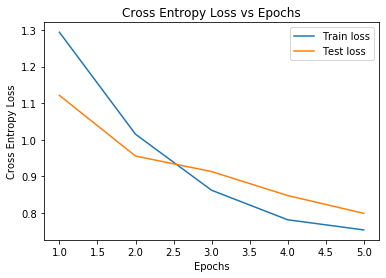

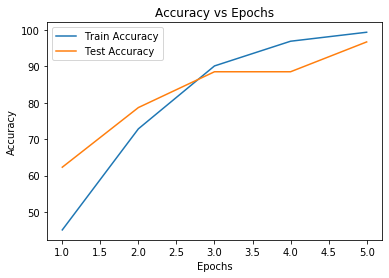

In [14]:
plot_result(model_output)